In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
import tensorflow as tf
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
import math
import mysql.connector

mydb = mysql.connector.connect(
    host = "localhost",
    user = "root",
    password = "",
    database ='etl'
)
 
# Creating an instance of 'cursor' class
# which is used to execute the 'SQL'
# statements in 'Python'
cursor = mydb.cursor()

In [3]:
df = pd.read_sql("SELECT * from polkadot", con=mydb)
df.head()

,id,date,high,low,open,close
0,1,2020-08-21,3.078,2.909,2.909,3.078
1,2,2020-08-22,4.464,2.970,3.078,4.464
2,3,2020-08-23,4.451,3.915,4.451,3.977
3,4,2020-08-24,4.730,3.977,3.977,4.594
4,5,2020-08-25,5.550,4.595,4.595,5.550


# **Preprosessing**

In [173]:
#df = pd.read_csv('/kaggle/input/btcinusd/BTC-Daily.csv')
# Removing all unessesary columns ( See Research )
df = df = df.drop(["id"], axis=1)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')
df.index = df.pop("date")
df

,high,low,open,close
date,,,,
2020-08-21,3.078,2.909,2.909,3.078
2020-08-22,4.464,2.970,3.078,4.464
2020-08-23,4.451,3.915,4.451,3.977
2020-08-24,4.730,3.977,3.977,4.594
2020-08-25,5.550,4.595,4.595,5.550
...,...,...,...,...
2022-08-19,8.092,7.250,8.080,7.313
2022-08-20,7.520,7.040,7.329,7.221
2022-08-21,7.530,7.171,7.221,7.440


# **Standardization**

In [174]:
# Scaler for N-Dimensional Array
df_features = df.drop(['close'],axis=1)
df_np = df_features.to_numpy()
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_np, (-1,1))
df_scaled[0]

array([0., 0., 0.])

In [175]:
# Scaler for 1D array
df_close = pd.DataFrame(df['close'])
df_close_np = df_close.to_numpy()
to_inverse_scale = MinMaxScaler()
df_close_scale = to_inverse_scale.fit_transform(df_close_np)
df_close_scale

array([[0.        ],
       [0.02730066],
       [0.01770801],
       [0.02986133],
       [0.04869209],
       [0.05871809],
       [0.05070123],
       [0.06090451],
       [0.06051056],
       [0.05538922],
       [0.0632682 ],
       [0.06261818],
       [0.06005752],
       [0.05211945],
       [0.04030098],
       [0.02074141],
       [0.03352506],
       [0.02968405],
       [0.02349905],
       [0.03187047],
       [0.02964466],
       [0.03106287],
       [0.04095099],
       [0.04406319],
       [0.04506776],
       [0.03900095],
       [0.03925701],
       [0.04471321],
       [0.04284195],
       [0.03647967],
       [0.03159471],
       [0.01924441],
       [0.02150961],
       [0.01816105],
       [0.02580366],
       [0.02649307],
       [0.0247006 ],
       [0.02397179],
       [0.02596124],
       [0.0278128 ],
       [0.02499606],
       [0.02501576],
       [0.02052474],
       [0.01950047],
       [0.02170659],
       [0.02141113],
       [0.01331547],
       [0.015

# **Converting Data to 3 Dimensions **

In [176]:
x = [] # The features needed for prediction.
y = [] # The expected result.

for i in range(len(df_scaled)-6):
    x.append(df_scaled[i:i+6])

for i in range(len(df_close_scale)-1):
        y.append(df_close_scale[i][0])


# Converting to Numpy array for easier reading by the ML-Algorithm
X = np.array(x)
Y = np.array(y)




# **Splitting the Data (Train/Test)**

In [177]:
train_no = math.floor(len(X) * 0.7) # 70% for training, 30% For Testing
total_no = len(X) 
X_Train, Y_Train = X[:train_no][:train_no], Y[:train_no]
X_Test, Y_Test = X[train_no: total_no - 1], Y[train_no: total_no - 1]

In [178]:
print(X_Train.shape, Y_Train.shape)
print(X_Test.shape, Y_Test.shape)

(508, 6, 3) (508,)
(218, 6, 3) (218,)


In [179]:
X_Train, Y_Train = X[:train_no], Y[:train_no]
X_Test, Y_Test = X[train_no: total_no - 1], Y[train_no: total_no - 1]

# **Developing The Model**

In [180]:
model = Sequential()
# Three layers, Final Output is in an array of 10 predictions
model.add(LSTM(50, return_sequences=True, input_shape=(6,3)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(20, return_sequences=False))
model.add(Dense(15))
model.add(Dense(1))
          

In [181]:
model.compile(optimizer='adam', loss='mean_squared_error') # Compling the Model

In [182]:
modeled = model.fit(X_Train, Y_Train, batch_size=1, epochs=10) # Training the model

Epoch 1/10
508/508 [==============================] - 6s 6ms/step - loss: 0.0062
Epoch 2/10
508/508 [==============================] - 3s 6ms/step - loss: 0.0015
Epoch 3/10
508/508 [==============================] - 3s 7ms/step - loss: 0.0013
Epoch 4/10
508/508 [==============================] - 3s 7ms/step - loss: 0.0014
Epoch 5/10
508/508 [==============================] - 3s 7ms/step - loss: 0.0013
Epoch 6/10
508/508 [==============================] - 3s 6ms/step - loss: 0.0013
Epoch 7/10
508/508 [==============================] - 3s 6ms/step - loss: 0.0014
Epoch 8/10
508/508 [==============================] - 3s 7ms/step - loss: 0.0013
Epoch 9/10
508/508 [==============================] - 3s 7ms/step - loss: 0.0011
Epoch 10/10
508/508 [==============================] - 3s 7ms/step - loss: 9.0148e-04


# **Testing the Model**

In [183]:
predictions = model.predict(X_Test)
predictions = to_inverse_scale.inverse_transform(predictions) # Reverse the standardization.


7/7 [==============================] - 1s 4ms/step


In [184]:
# Putting the predictions in an array to convert into dataframe column later.
valid = []
for i in range(len(predictions)):
    valid.append(predictions[i][0]) # Using the final prediction in the array.
    

# **Validating the Results**

In [185]:
new_df = pd.DataFrame(df[train_no: total_no - 1])

new_df = new_df.drop(["high","low","open"], axis=1)

new_df['Prediction'] = valid


new_df

,close,Prediction
date,,
2022-01-11,25.573,24.440556
2022-01-12,27.292,25.282072
2022-01-13,25.770,25.634499
2022-01-14,27.731,25.661869
2022-01-15,27.630,25.807281
...,...,...
2022-08-12,9.480,9.294208
2022-08-13,9.301,9.241293
2022-08-14,8.950,9.059711


In [186]:
#new_df.plot()
first = new_df.iloc[2020-11-14]
first

IndexError: single positional indexer is out-of-bounds

In [187]:
new_df.corr() # Accuracy around 99.5%

,close,Prediction
close,1.000000,0.997191
Prediction,0.997191,1.000000


In [188]:
X_Test

array([[[0.44166249, 0.41827479, 0.40854389],
        [0.47172682, 0.45802642, 0.44494179],
        [0.47363353, 0.46267324, 0.4791998 ],
        [0.47729286, 0.45995414, 0.44892711],
        [0.48769308, 0.48604939, 0.48756307],
        [0.48898348, 0.49445019, 0.48556059]],

       [[0.47172682, 0.45802642, 0.44494179],
        [0.47363353, 0.46267324, 0.4791998 ],
        [0.47729286, 0.45995414, 0.44892711],
        [0.48769308, 0.48604939, 0.48756307],
        [0.48898348, 0.49445019, 0.48556059],
        [0.47482763, 0.450904  , 0.4866011 ]],

       [[0.47363353, 0.46267324, 0.4791998 ],
        [0.47729286, 0.45995414, 0.44892711],
        [0.48769308, 0.48604939, 0.48756307],
        [0.48898348, 0.49445019, 0.48556059],
        [0.47482763, 0.450904  , 0.4866011 ],
        [0.44204769, 0.43345305, 0.44706206]],

       ...,

       [[0.12470629, 0.12024918, 0.12566504],
        [0.12137437, 0.11629228, 0.11869564],
        [0.11311198, 0.11635316, 0.11543672],
        [0.1173

In [189]:
test = X_Test[787:]

tests = model.predict(test)
tests =to_inverse_scale.inverse_transform(tests)
t = []
for i in range(len(tests)):
    t.append(tests[i][0])

t

ValueError: Unexpected result of `predict_function` (Empty batch_outputs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

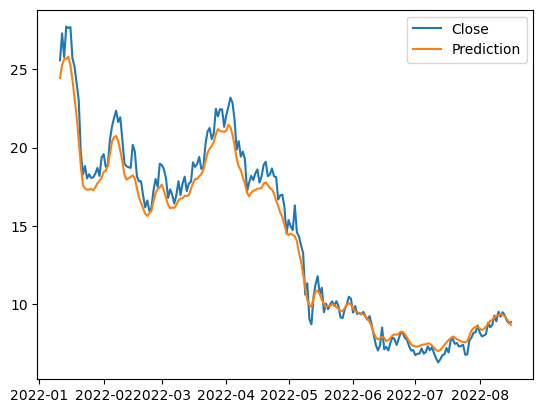

In [190]:
import matplotlib.pyplot as plt
plt.plot(new_df['close'])
plt.plot(new_df['Prediction'])
plt.legend(["Close","Prediction"])
plt.show()

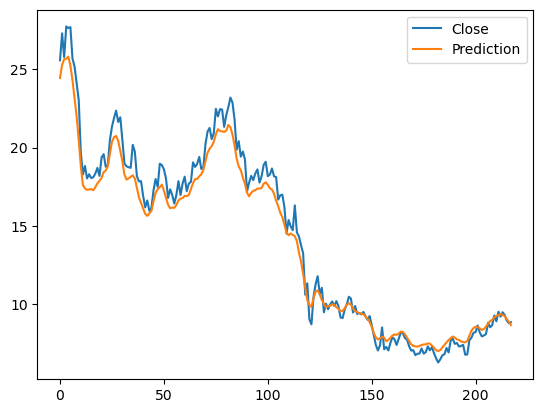

In [191]:
import matplotlib.pyplot as plt

close = new_df['close'].to_numpy()
predict = new_df['Prediction'].to_numpy()

plt.plot(close)
plt.plot(predict)

plt.legend(["Close","Prediction"])
plt.show()

<AxesSubplot:xlabel='date'>

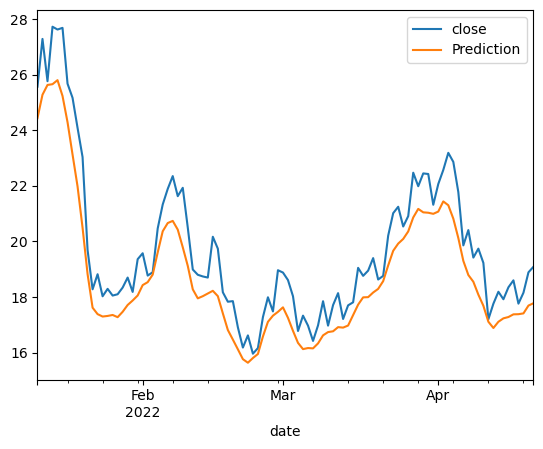

In [192]:
test_df=new_df.head(100)
test_df.plot()

In [193]:
#import joblib
#import pickle
import keras

In [195]:
model.save('Polkadot_Model')

INFO:tensorflow:Assets written to: Polkadot_Model\assets


INFO:tensorflow:Assets written to: Polkadot_Model\assets
